In [22]:
#imports and setup 
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt

from uuv_mission.dynamic import Mission, ClosedLoop, Submarine
from uuv_mission.control import PDController

# Load mission for a quick sanity check
m = Mission.from_csv("../data/mission.csv")  # path relative to the notebook
len(m.reference), m.reference[:5]

(100, array([0.        , 2.9239131 , 5.51432416, 7.48758532, 8.65202856]))

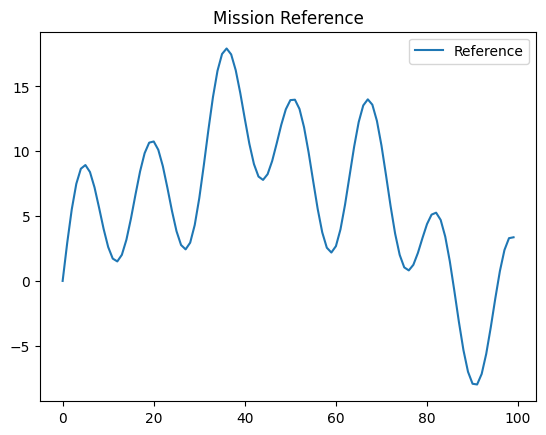

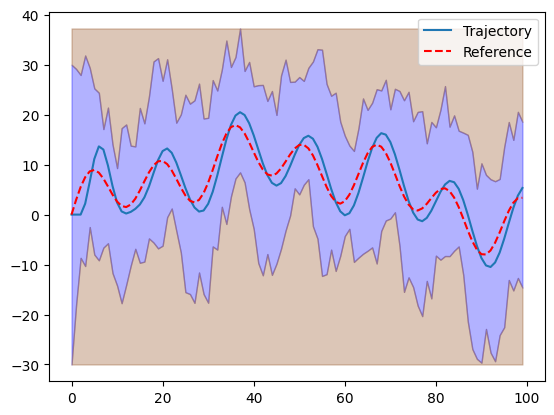

In [23]:
#zero-disturbance baseline (sanity check)

# Instantiate plant and PD controller
sub = Submarine()
ctl = PDController(kp=0.15, kd=0.6)
cl = ClosedLoop(sub, ctl)

# Simulate with zero disturbance
dist = np.zeros(len(m.reference))
traj = cl.simulate(mission=m, disturbances=dist)

# Plot reference for comparison
plt.figure()
plt.plot(m.reference, label="Reference")
plt.title("Mission Reference")
plt.legend()
plt.show()

# Plot the simulated trajectory
plt.figure()
traj.plot_completed_mission(m)



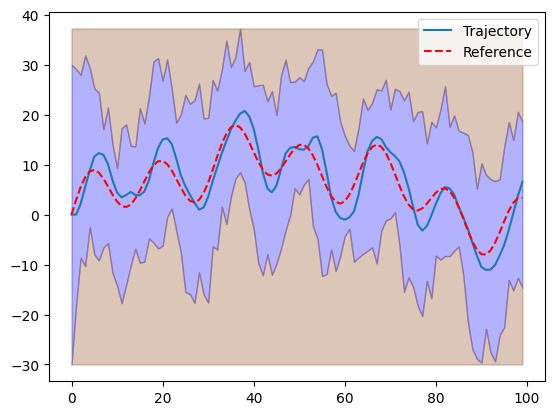

In [24]:
#random disturbances test
# variance controls disturbance size; start small and increase gradually
traj_rand = cl.simulate_with_random_disturbances(mission=m, variance=0.5)

# Visualize completed mission 
traj_rand.plot_completed_mission(m)



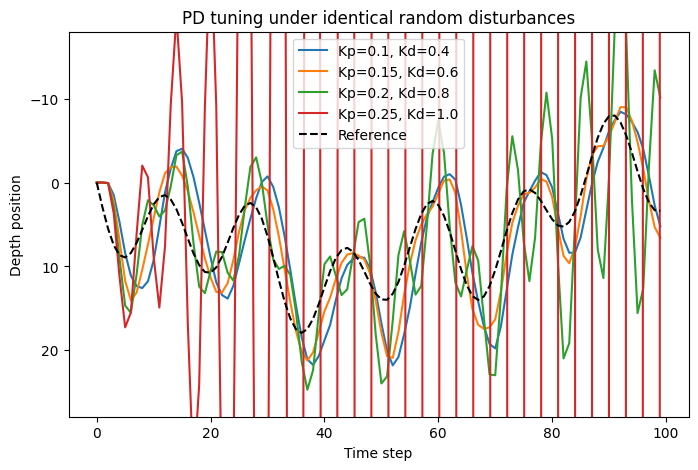

In [ ]:
#gain tuning helper 

# Gains to compare
gains = [(0.1, 0.4), (0.15, 0.6), (0.2, 0.8), (0.25, 1.0)]

# Build one fixed disturbance sequence for FAIR comparison
T = len(m.reference)
rng = np.random.default_rng(0)          # reproducible random generator
variance = 0.5
disturbance = rng.normal(0, variance, T)  # same array reused for all gains

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

for Kp, Kd in gains:
    ctl = PDController(Kp, Kd)
    cl = ClosedLoop(Submarine(), ctl)
    # Use simulate() so *every* gain sees the same disturbance
    traj = cl.simulate(mission=m, disturbances=disturbance)
    ax.plot(traj.position[:, 1], label=f"Kp={Kp}, Kd={Kd}")

# Overlay the target (reference) to show tracking quality
ax.plot(m.reference, "k--", linewidth=1.5, label="Reference")

# Depth axis: ocean-depth convention (down is positive)
# Choose neat limits around the reference range so unstable runs don't blow up the scale
ref_min, ref_max = float(np.min(m.reference)), float(np.max(m.reference))
margin = 10.0
ax.set_ylim(ref_max + margin, ref_min - margin)   # reversed order == inverted y-axis

ax.set_title("PD tuning under identical random disturbances")
ax.set_xlabel("Time step")
ax.set_ylabel("Depth position")
ax.legend()
plt.show()